# Implementation of a Language Model (RNN and Transformer-based)
#### Autorka: Julia Rybska
source code: https://github.com/juliaryb/computational-linguistics

In [1]:
import os, math, time, json, csv, random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import config  # uses your uploaded config.py
from prep_data import download_high_quality
from tokenizer import ensure_char_tokenizer, ensure_spm_tokenizer
from model import LSTMModel, TransformerDecoderOnly
from data import LanguageModelDataset
from generate import generate_text

### Data
- pobrane ze speakleash i odfiltrowane wg high quality
- train: 1000 novels corpus CLARIN
- val: wolne lektury corpus

In [2]:
# Download high-quality Polish datasets (once)
# download_high_quality("1000_novels_corpus_CLARIN-PL", config.TRAIN_PATH)
# download_high_quality("wolne_lektury_corpus", config.VALID_PATH)

### Training
- Training can be run using `python train.py` after setting desired config parameters in `config.py`.
- The same tokeniser (sentence-piece) was used for both architectures (with vocabulary size 8000). 
- One section is devoted to the LSTM architecture and results. 
- Another to the transformer

### LSTM

In [ ]:
# config
print("DEVICE:", config.DEVICE)
print("MODEL_ARCH:", config.MODEL_ARCH)
print("TOKENIZER_TYPE:", config.TOKENIZER_TYPE)
print("SEQ_LEN:", config.SEQ_LEN, "BATCH_SIZE:", config.BATCH_SIZE, "EPOCHS:", config.EPOCHS)

DEVICE: cpu
MODEL_ARCH: lstm
TOKENIZER_TYPE: spm
SEQ_LEN: 64 BATCH_SIZE: 16 EPOCHS: 8


In [11]:
# train the LSTM model (and tokeniser - it'll then be reused for the transformer)
!python train.py

Using device: cpu
sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=/home/julia/Documents/lingwistyka/computational-linguistics/data/lektury_train.txt --model_prefix=/home/julia/Documents/lingwistyka/computational-linguistics/tokenizers/sentence-piece --model_type=unigram --vocab_size=8000 --character_coverage=1.0 --normalization_rule_name=nfkc --add_dummy_prefix=true --byte_fallback=false --unk_id=0 --bos_id=1 --eos_id=2 --pad_id=3 --input_sentence_size=2000000 --shuffle_input_sentence=true
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /home/julia/Documents/lingwistyka/computational-linguistics/data/lektury_train.txt
  input_format: 
  model_prefix: /home/julia/Documents/lingwistyka/computational-linguistics/tokenizers/sentence-piece
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 2000000
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_f

In [5]:
# check tokenizer
train_path = os.path.join(config.DATA_DIR, config.TRAIN_FILE)
tok_path   = os.path.join(config.DATA_DIR, config.TOKENIZER_FILE)

tok = ensure_spm_tokenizer(train_path, tok_path)

print("Vocab size:", tok.get_vocab_size(), "pad/bos/eos/unk:",
      tok.pad_id, tok.bos_id, tok.eos_id, tok.unk_id)

# quick sanity
s = "Może fajnie byłoby"
ids = tok.encode(s)
print(ids[:20], "... ->", tok.decode(ids))

Vocab size: 8000 pad/bos/eos/unk: 3 1 2 0
[1, 657, 634, 29, 46, 2257, 2] ... -> Może fajnie byłoby


In [26]:
print("embedding layer size:", config.EMBED_DIM)
print("hidden layer size:", config.HIDDEN_DIM)
print("num of layers:", config.NUM_LAYERS)
print("dropout:", config.DROPOUT)

embedding layer size: 128
hidden layer size: 128
num of layers: 2
dropout: 0.1


In [8]:
vocab_size = tok.get_vocab_size()
model = LSTMModel(vocab_size, config.EMBED_DIM, config.HIDDEN_DIM, config.NUM_LAYERS,
                      dropout=config.DROPOUT, tokenizer=tok).to(config.DEVICE)

print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))


Params: 2320192


#### Metrics and results

In [10]:
df = pd.read_csv(config.LOG_CSV)
df

,epoch,train_loss,train_ppl,val_loss,val_ppl,epoch_time_sec
0,1,7.134354,1254.326489,6.918037,1010.334680,7.554808
1,2,6.691460,805.497527,6.673030,790.787815,7.745584
2,3,6.465634,642.671968,6.569805,713.230508,7.638299
3,4,6.298223,543.605065,6.450093,632.761293,7.514045
4,5,6.153760,470.482866,6.373709,586.227970,7.875322
5,6,6.045913,422.383200,6.302482,545.925121,8.031184
6,7,5.961341,388.130274,6.257265,521.789683,8.351541
7,8,5.889058,361.064848,6.225413,505.431981,7.883004


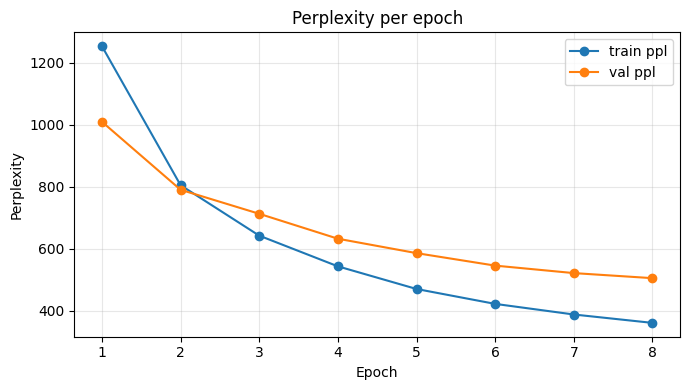

In [11]:
plt.figure(figsize=(7,4))
plt.plot(df["epoch"], df["train_ppl"], marker="o", label="train ppl")
plt.plot(df["epoch"], df["val_ppl"], marker="o", label="val ppl")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Perplexity per epoch")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

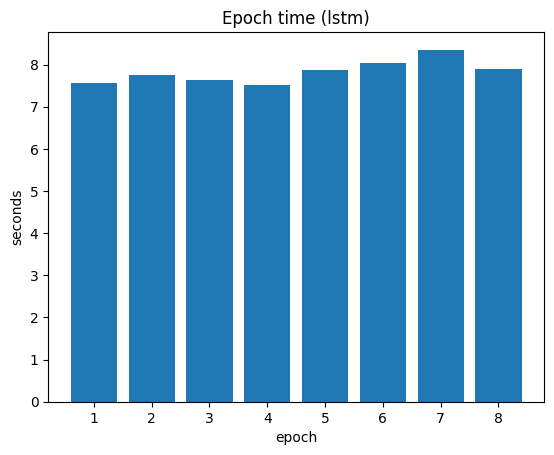

In [13]:
plt.figure()
plt.bar(df["epoch"], df["epoch_time_sec"])
plt.xlabel("epoch"); plt.ylabel("seconds"); plt.title(f"Epoch time ({config.MODEL_ARCH})")
plt.show()

#### prompts and model's creativity

In [14]:
PROMPTS = [
    "Może fajnie byłoby",
    "Na początku było",
    "Kiedy słońce zaszło",
    "W pewnym momencie",
    "To nie jest zwykła opowieść",
    "Niech Cię nie zdziwi",
    "W Krakowie, na rynku",
    "Zaraz będzie ciemno",
    "Czasem wystarczy",
    "Gdybyś tylko wiedział"
]

In [20]:
# load best weights for the selected arch
sd = torch.load(config.MODEL_SAVE_PATH, map_location=config.DEVICE, weights_only=True)
model.load_state_dict(sd)
model.eval()

gen_rows = []
for i, p in enumerate(PROMPTS, 1):
    t0 = time.perf_counter()
    out = generate_text(model, tok, prompt=p, max_len=120, temperature=0.9)
    dt = time.perf_counter() - t0
    gen_rows.append({"idx": i, "prompt": p, "gen_time_s": dt, "len_chars": len(out), "output": out})
    print("\n", out)

gen_df = pd.DataFrame(gen_rows)
display(gen_df[["idx","prompt","gen_time_s","len_chars"]])

True

 Może fajnie byłobyyiąc, które nie ciało. ⁇ Wdyrzuceniaę, ⁇ Podkrętsz się poży, ⁇ A Prawowej jest je? ⁇ Mywsza i te wsku... ⁇ Ta Łowie urerzych gościa, a takć ciekaw. ⁇ A gożł dzienniku, aby z jej dwa zpieżi w wyłgoz innych, ⁇ Ty niezewsznej ty widnokręga — ⁇ Weśś się zwęły, ⁇ Kdybram aniżeli kuścit głową, ⁇ Sbajach przez
True

 Na początku byłoiów przyłą dnia, ⁇ — to byatyć ma światło, ⁇ e niestetyło z koklem i godzin. Zaczęłdziy, że w jabierlu!” do swej zawiele. ⁇ Cędni na nią cenyych, odda jej wielu. ⁇ Asmkapno wy wodą, a każdy czas tam razem po ogólnezamnie, ⁇ I to przeców twojej w nich środek: ⁇ Pody Vytażli nikczemna,ukdni, ⁇ D boca! ⁇ Oboga zastąpiłam sięujący!
True

 Kiedy słońce zaszło z ciemneki, Umiem bardzo. — Zdawało wiatry Agali, czy cię wieści nic piskonie osgi i milczał. ⁇ Delli w pomiędzy schodów, ale ia fra cili niepodtekeń, to śmiałem, zsięgu — najczydy Bogu w otchłani nagle we kobiet jej krótkoem raz, wiele zechcena duszy ⁇ Aby, nie zarazem widząc ku kryrzy, ⁇

,idx,prompt,gen_time_s,len_chars
0,1,Może fajnie byłoby,0.060127,322
1,2,Na początku było,0.038274,345
2,3,Kiedy słońce zaszło,0.038979,413
3,4,W pewnym momencie,0.036596,384
4,5,To nie jest zwykła opowieść,0.061143,417
5,6,Niech Cię nie zdziwi,0.054255,387
6,7,"W Krakowie, na rynku",0.035853,377
7,8,Zaraz będzie ciemno,0.037060,367
8,9,Czasem wystarczy,0.035134,395
9,10,Gdybyś tylko wiedział,0.037241,403


### Transformer

In [28]:
# config
import importlib
import config
importlib.reload(config)

print("DEVICE:", config.DEVICE)
print("MODEL_ARCH:", config.MODEL_ARCH)
print("TOKENIZER_TYPE:", config.TOKENIZER_TYPE)
print("SEQ_LEN:", config.SEQ_LEN, "BATCH_SIZE:", config.BATCH_SIZE, "EPOCHS:", config.EPOCHS)

DEVICE: cpu
MODEL_ARCH: transformer
TOKENIZER_TYPE: spm
SEQ_LEN: 64 BATCH_SIZE: 16 EPOCHS: 8


In [30]:
# train the transformer (same tokenizer used that was trained during LSTM training)
!python train.py

Using device: cpu
Model created. Total parameters: 2,343,680

--- Starting Training ---

[Epoch 1/8]
  Batch 100/193, Loss: 12.9196
  > Train Epoch Time: 13.89s
  > End of Epoch, Train Loss: 15.2355
  > Validation Loss: 8.8245, Validation Perplexity: 6798.8057
  > Epoch Time (train+val): 13.89s
  > New best model saved to /home/julia/Documents/lingwistyka/computational-linguistics/checkpoints/best_tx_model.pth (Perplexity: 6798.8057)

[Epoch 2/8]
  Batch 100/193, Loss: 7.7548
  > Train Epoch Time: 14.02s
  > End of Epoch, Train Loss: 7.8075
  > Validation Loss: 7.3981, Validation Perplexity: 1632.9092
  > Epoch Time (train+val): 14.02s
  > New best model saved to /home/julia/Documents/lingwistyka/computational-linguistics/checkpoints/best_tx_model.pth (Perplexity: 1632.9092)

[Epoch 3/8]
  Batch 100/193, Loss: 6.8773
  > Train Epoch Time: 15.32s
  > End of Epoch, Train Loss: 6.9926
  > Validation Loss: 7.0868, Validation Perplexity: 1196.0396
  > Epoch Time (train+val): 15.32s
  > New 

In [29]:
print("embedding layer size:", config.TX_D_MODEL)
print("attention head size:", config.TX_N_HEAD)
print("num of layers:", config.TX_N_LAYER)
print("feed forward layer size:", config.TX_D_FF)
print("dropout:", config.DROPOUT)


embedding layer size: 128
attention head size: 8
num of layers: 4
feed forward layer size: 1024
dropout: 0.1


In [35]:
model = TransformerDecoderOnly(
        vocab_size=vocab_size,
        d_model=config.TX_D_MODEL, n_layer=config.TX_N_LAYER, n_head=config.TX_N_HEAD, d_ff=config.TX_D_FF,
        dropout=config.TX_DROPOUT, pad_id=tok.pad_id
    ).to(config.DEVICE)

print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Params: 2343680


In [38]:
df = pd.read_csv(config.LOG_CSV)
df = df[1:] # drop the first train perplexity value to make the plot readable

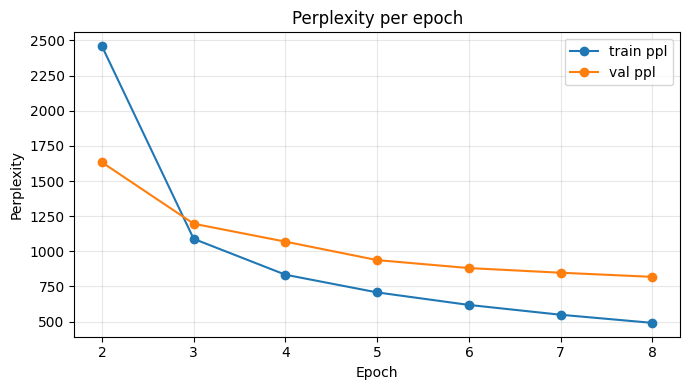

In [39]:
plt.figure(figsize=(7,4))
plt.plot(df["epoch"], df["train_ppl"], marker="o", label="train ppl")
plt.plot(df["epoch"], df["val_ppl"], marker="o", label="val ppl")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Perplexity per epoch")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

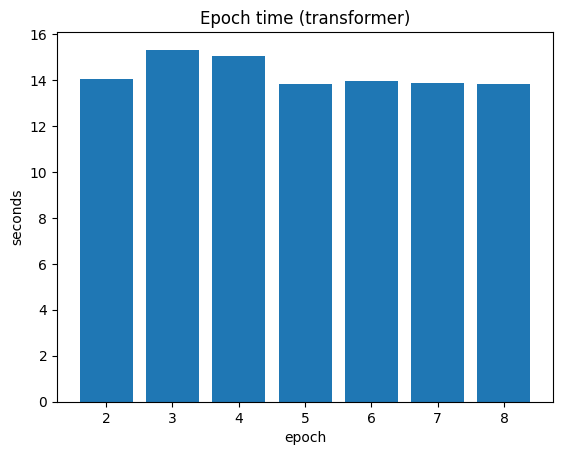

In [40]:
plt.figure()
plt.bar(df["epoch"], df["epoch_time_sec"])
plt.xlabel("epoch"); plt.ylabel("seconds"); plt.title(f"Epoch time ({config.MODEL_ARCH})")
plt.show()

In [44]:
PROMPTS = [
    "Może fajnie byłoby",
    "Na początku było",
    "Kiedy słońce zaszło",
    "W pewnym momencie",
    "To nie jest zwykła opowieść",
    "Niech Cię nie zdziwi",
    "W Krakowie, na rynku",
    "Zaraz będzie ciemno",
    "Czasem wystarczy",
    "Gdybyś tylko wiedział"
]

# load best weights for the selected arch
sd = torch.load(config.MODEL_SAVE_PATH, map_location=config.DEVICE, weights_only=True)
model.load_state_dict(sd)
model.eval()

gen_rows = []
for i, p in enumerate(PROMPTS, 1):
    t0 = time.perf_counter()
    out = generate_text(model, tok, prompt=p, max_len=120, temperature=0.9)
    dt = time.perf_counter() - t0
    gen_rows.append({"idx": i, "prompt": p, "gen_time_s": dt, "len_chars": len(out), "output": out})
    print("\n", out)

gen_df = pd.DataFrame(gen_rows)
display(gen_df[["idx","prompt","gen_time_s","len_chars"]])

False

 Może fajnie byłoby! ⁇ A poznać upiękni krwawą ⁇ Byiłam się akończy osłupiał znażnie pokusa Łu kuchenn z o czarne, ⁇ tk o medy Johny, ⁇ A. ⁇ Bażlaz mógłden roz sił. ⁇ Pe znaki, ⁇ W ręce, ⁇ Nach płynąnych trzyma bardzoowoto i Gżów. ⁇ — To wyZ wją tak śpiewać w polepuszczająclady; ⁇ Ś me bardziej! ⁇ Ka! niepatrywać za losi, ha którark męża ów bł, ata de nas rozm
False

 Na początku było życie,ik się to przy Ja wolny. ⁇ W także ztąstrob rozkoj wzgdy, kury źleło się wzywaćtał po tak od kopalni. ⁇ W jest przy Europie! patrząc; niejsze ty w strumienia, wprost reform dlaczego się on ludzi. ⁇ Nie rozszcze i ⁇ Wgoku, kanli w do czas3 miała śmiechuch nie wy mnieoni wła całesi kwiatyży! ⁇ C klasztor pow niepoktał tak jadł, ⁇ Awie spełniny, ⁇ W wstydem, ⁇ — swoim załugrzy M pi
False

 Kiedy słońce zaszłoe francuj gdybyżracy obok.hauć ich w ocielamimy tylko Kar niesłychanie koraliy przerzania odwrócił. Ale bez przymda, to pisać się o pod jednym z wyobrażenie wire możeł;; a swychszczy sobie m

,idx,prompt,gen_time_s,len_chars
0,1,Może fajnie byłoby,0.364809,361
1,2,Na początku było,0.361464,404
2,3,Kiedy słońce zaszło,0.319198,429
3,4,W pewnym momencie,0.284924,416
4,5,To nie jest zwykła opowieść,0.341649,441
5,6,Niech Cię nie zdziwi,0.359402,441
6,7,"W Krakowie, na rynku",0.306854,367
7,8,Zaraz będzie ciemno,0.328671,347
8,9,Czasem wystarczy,0.282444,378
9,10,Gdybyś tylko wiedział,0.286585,385


,arch,best_val_ppl,median_epoch_s
0,lstm,505.431981,7.810453
1,transformer,818.278449,13.929335


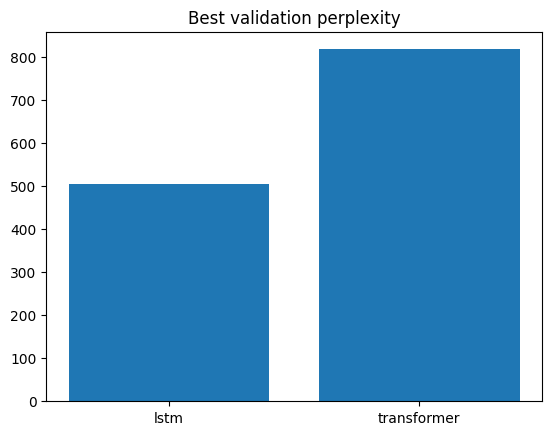

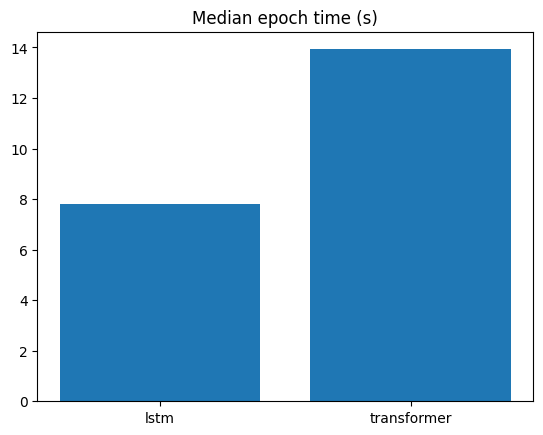

In [42]:
# adjust these two paths:
csv_lstm = os.path.join(config.LOGS_DIR, "training_metrics_lstm.csv")
csv_tx   = os.path.join(config.LOGS_DIR, "training_metrics_transformer.csv")

dl = pd.read_csv(csv_lstm)
dt = pd.read_csv(csv_tx)

summary = pd.DataFrame([
    {"arch":"lstm", "best_val_ppl": dl["val_ppl"].min(), "median_epoch_s": dl["epoch_time_sec"].median()},
    {"arch":"transformer", "best_val_ppl": dt["val_ppl"].min(), "median_epoch_s": dt["epoch_time_sec"].median()},
])
display(summary)

plt.figure()
plt.bar(summary["arch"], summary["best_val_ppl"])
plt.title("Best validation perplexity"); plt.show()

plt.figure()
plt.bar(summary["arch"], summary["median_epoch_s"])
plt.title("Median epoch time (s)"); plt.show()

# CONCLUSIONS
- **a tokenizer affects the perplexity value** - I trained the models on two different tokenizers (character-level and sentencepiece). The character-level model gave very low ppl values (~30), while sentencepiece was much higher (~800). This difference is expected, because the size of the vocabulary affects how sentences get split and how many tokens we end up with. When the vocabulary is smaller, the tokenizer must split words into much smaller pieces, which creates more tokens for the same sentence. With a fixed sequence length, less semantic context fits in a single model window — and the model must predict extremely fine-grained token steps (single characters), which are “easy” statistically but not semantically meaningful. Larger subwords are harder units to predict but capture more meaning per token. This explains why perplexity values are not directly comparable across tokenizers — **models should only be compared under the same tokenizer**.
- **the transformer did not outperform the LSTM under this small experiment setup** — even though Transformers are the dominant architecture today, in this experiment the LSTM reached lower perplexity and trained faster. This is most likely because the dataset size, sequence length and model scale were all very small. LSTMs tend to handle low-data / short-context setups better.
- **interpretation / expected behaviour from literature** — this result does not mean the transformer architecture is worse in general. Literature shows that transformers typically start outperforming recurrent models once the model size, context length and training data become larger. My small toy setting simply does not reveal this advantage — so the comparison result should be read only within this limited scale, not as a general rule.
- I managed to configure the project for athena - but didn't manage to train it there in time, and also to create the notebook there in time - will do for the next part :) This should also allow observing how the tranformer's behaviour changes when scaling up. 